In [2]:
import numpy as np
import scipy as sc
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt

<h1>Invertierter Verstärker<h1>

Verstärkung

modified transition index 0:
18
Leerlaufverstärkung:
Mittelwert: 174.64
Unsicherheit des Mittelwerts: 2.611
f_cutoff = 31700.0 $pm$ 700.0
modified transition index 1:
22
Leerlaufverstärkung:
Mittelwert: 123.26
Unsicherheit des Mittelwerts: 1.285
f_cutoff = 64700.0 $pm$ 300.0
modified transition index 2:
24
Leerlaufverstärkung:
Mittelwert: 84.70
Unsicherheit des Mittelwerts: 1.044
f_cutoff = 82600.0 $pm$ 1400.0


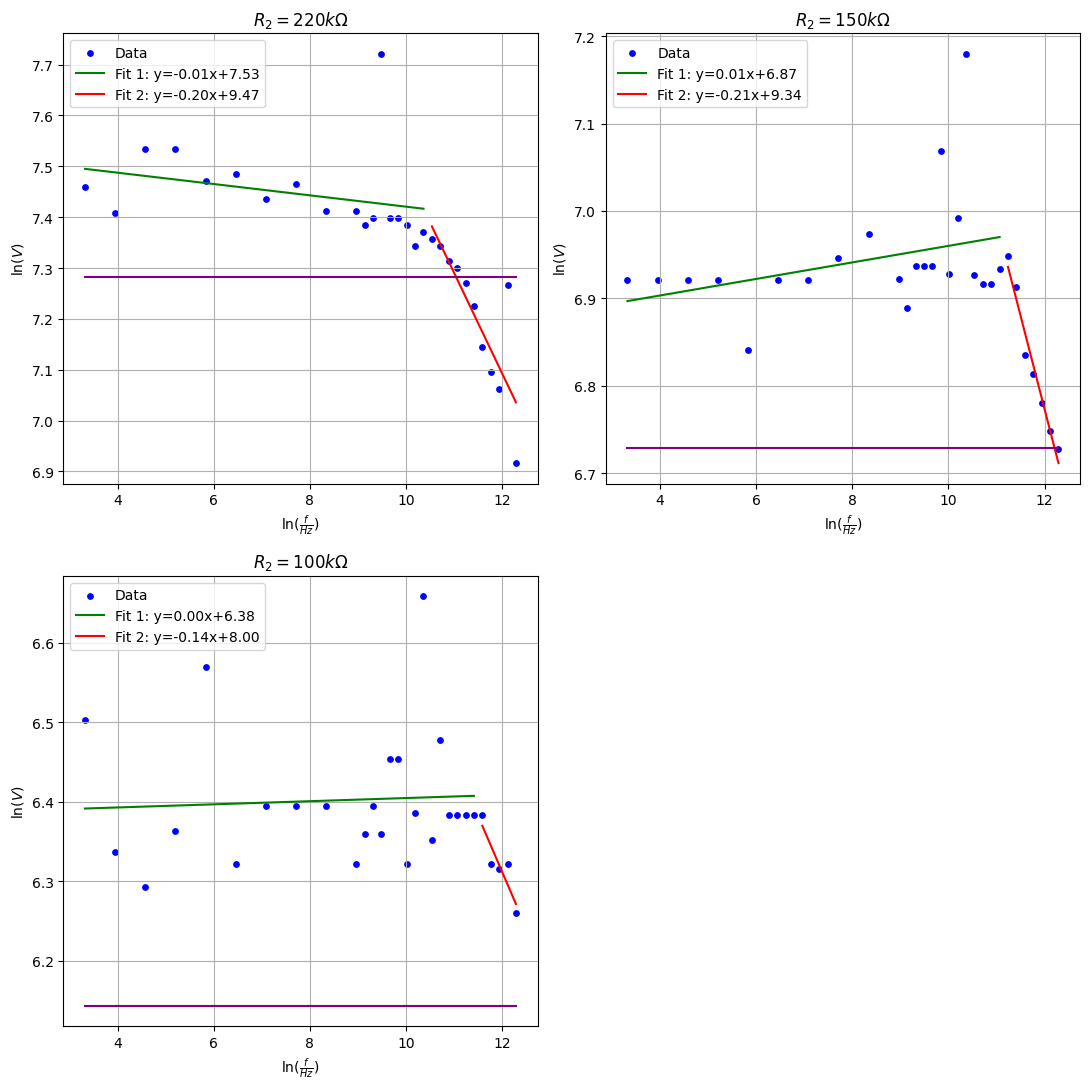

In [3]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Invert_220k": "../data/Invert_220k.txt",

    "Invert_150k": "../data/Invert_150k.txt",

    "Invert_100k": "../data/Invert_100k.txt"

}



dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def toplabel(key):
    if key == "Invert_220k":
        return r"$R_2 = 220k\Omega$"
    if key == "Invert_150k":
        return r"$R_2 = 150k\Omega$"
    if key == "Invert_100k":
        return r"$R_2 = 100k\Omega$"

def modify_cutoff_point(transition_index,i):
    if i == 0:
        transition_index += 6
    if i == 1:
        transition_index += 8
    if i == 2:
        transition_index += 10

    return transition_index

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100
    
def intersect_error( popt1, popt2, errors1, errors2 ):
    a1 = popt1[0]
    a2 = popt2[0]
    b1 = popt1[1]
    b2 = popt2[1]

    da1 = errors1[0]
    da2 = errors2[0]
    db1 = errors1[1]
    db2 = errors2[1]

    return np.sqrt(np.exp((b2 - b1) / (a1 - a2)) * ((db1 / (a1 - a2))**2 + (db2 / (a1 - a2))**2 + ((b2 - b1) * da1 / (a1 - a2)**2)**2 + ((b2 - b1) * da2 / (a1 - a2)**2)**2))


def print_mean_error(daten):
    N = len(daten)

    # Mittelwert berechnen
    mittelwert = np.mean(daten)

    # Quadratische Abweichungen vom Mittelwert
    abweichungen = (daten - mittelwert)**2

    # Unsicherheit des Mittelwerts berechnen
    sigma_mittelwert = np.sqrt(np.sum(abweichungen) / (N * (N - 1)))

    # Ausgabe
    print(f"Mittelwert: {mittelwert:.2f}")
    print(f"Unsicherheit des Mittelwerts: {sigma_mittelwert:.3f}")
    
# Prepare plots
fig, axes = plt.subplots(2, 2, figsize=(11, 11))
axes = axes.flatten()
fig.delaxes(axes[3])

for i, (key, df) in enumerate(dataframes.items()):

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()
    

    # Log-transform frequency and gain

    log_frequencies = np.log2(frequencies)

    log_gains = np.log2(gains)

    # Adjust transition point selection (using relative slopes for smoother split)

    slopes = np.diff(log_gains) / np.diff(log_frequencies)

    transition_index = np.argmax(slopes < -0.5)  # Find where slope becomes significantly negative
    print("modified transition index " + str(i) + ":")

    transition_index = modify_cutoff_point(transition_index, i)
    print(transition_index)
    print( "Leerlaufverstärkung:")
    
    print_mean_error(gains[:transition_index])

    # Fit the first region (constant gain)

    popt1, cov_mat1 = curve_fit(linear_fit, log_frequencies[:transition_index], log_gains[:transition_index])

    errors1 = np.sqrt(np.diag(cov_mat1))

    fit1 = linear_fit(log_frequencies[:transition_index], *popt1)

    # Fit the second region (falling gain)

    popt2, cov_mat2 = curve_fit(linear_fit, log_frequencies[transition_index:], log_gains[transition_index:])

    errors2 = np.sqrt(np.diag(cov_mat2))

    fit2 = linear_fit(log_frequencies[transition_index:], *popt2)

    fcut = np.exp((popt2[1]-popt1[1]) / (popt1[0]-popt2[0]))
    errfcut = intersect_error(popt1, popt2, errors1, errors2)


    print(r"f_cutoff = " + str(np.round( fcut, -2 )) + r" $pm$ " + str( np.round(errfcut, -2) ))

    # Plot original data

    axes[i].scatter(log_frequencies, log_gains, label="Data", color='blue', s=15)

    # Plot the fits

    axes[i].plot(log_frequencies[:transition_index], fit1, label=f"Fit 1: y={popt1[0]:.2f}x+{popt1[1]:.2f}", color='green')

    axes[i].plot(log_frequencies[transition_index:], fit2, label=f"Fit 2: y={popt2[0]:.2f}x+{popt2[1]:.2f}", color='red')

    axes[i].plot([log_frequencies[0],log_frequencies[-1]], [np.log2(get_amp(i)/np.sqrt(2)),np.log2(get_amp(i)/np.sqrt(2))], color='purple' )



    # Add labels, title, legend

    axes[i].set_title(toplabel(key))

    axes[i].set_xlabel(r"$\ln(\frac{f}{Hz})$")

    axes[i].set_ylabel(r"$\ln(V)$")

    axes[i].legend()

    axes[i].grid()

# Adjust layout and show the plots
plt.tight_layout()


plt.savefig("../figures/inverted_gain")

plt.show()  







Phase

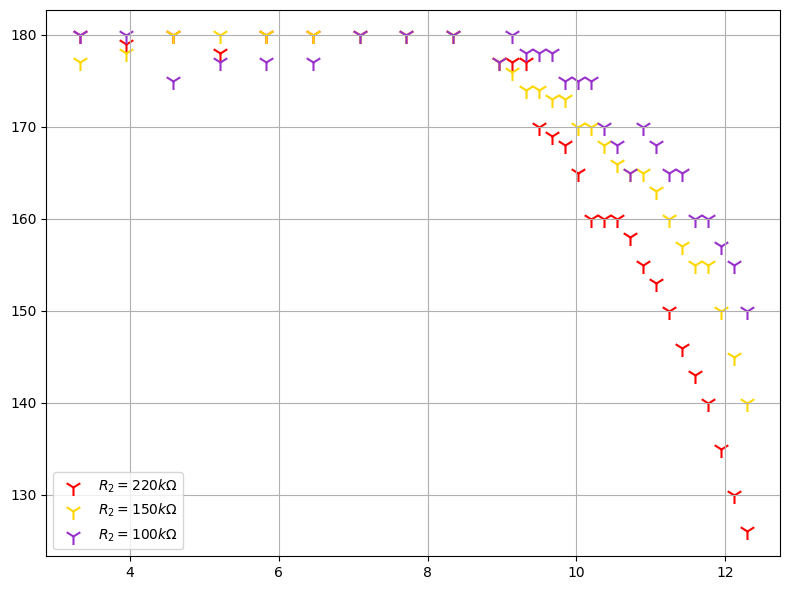

In [4]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Invert_220k": "../data/Invert_220k.txt",

    "Invert_150k": "../data/Invert_150k.txt",

    "Invert_100k": "../data/Invert_100k.txt"

}



dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def colour(key):
    if key == "Invert_220k":
        return "red"
    if key == "Invert_150k":
        return "gold"
    if key == "Invert_100k":
        return "darkorchid"
    
def toplabel(key):
    if key == "Invert_220k":
        return r"$R_2 = 220k\Omega$"
    if key == "Invert_150k":
        return r"$R_2 = 150k\Omega$"
    if key == "Invert_100k":
        return r"$R_2 = 100k\Omega$"

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100


# Prepare plots
plt.figure(figsize=(8, 6))

for i, (key, df) in enumerate(dataframes.items()):

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()

    phases = df['Phase_Deg'].astype(float).to_numpy()

    # Log-transform frequency and gain

    log_frequencies = np.log2(frequencies)

   

    axes[i].scatter(log_frequencies, phases, label="Data", color='blue', s=15)
  

    plt.scatter(log_frequencies, phases, marker="1", label=toplabel(key), color=colour(key), s=150)
    # Add labels, title, legend

# Adjust layout and show the plots
plt.tight_layout()

plt.grid(True)
plt.savefig("../figures/inverted_phase")
plt.legend(loc="lower left")
plt.show()  







<h1>Integrator<h1>

Integrator
Zeitkonstante = 0.008903277207914501 $\pm$ -0.0002656732443926156
a = -0.8442767159698955 $\pm$ 0.02847016403847765
b = 4.721335844414083 $\pm$ 0.029839938506738547
 
Differentiator
Zeitkonstante = 0.07985498989339085 $\pm$ -0.010977779204795382
a = 1.0355088514630344 $\pm$ 0.10086328485141974
b = 2.5275429154358804 $\pm$ 0.13747142438376228
 


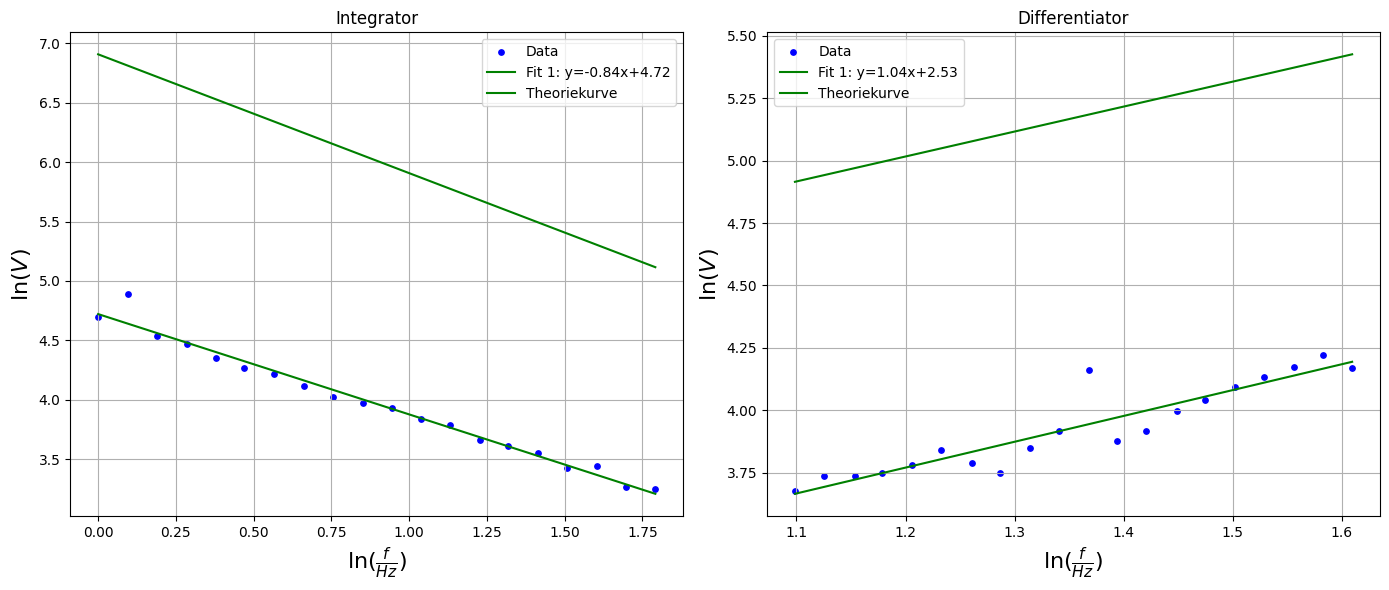

In [7]:
def linear_fit(x, a, b):

    return a * x + b



# Load the data files into dataframes

file_paths = {

    "Integrator": "../data/Integrator.txt",

    "Differentiator": "../data/Differentiator.txt"

}

dataframes = {}

for key, path in file_paths.items():

    # Read the file, split by semicolon, and skip the header

    data = pd.read_csv(path, delimiter=';', skiprows=1, names=['Frequency_Hz', 'Amplified_V', 'Unamplified_mV', 'Phase_Deg'])

    # Remove any extra whitespace from column names and values

    data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    dataframes[key] = data

# Liste zum Speichern der Figure-Objekte
figures = []

def toplabel(key):
    if key == "Integrator":
        return "Integrator"
    if key == "Differentiator":
        return "Differentiator"


# Unterscheidung der Theoriekurven
def theoriekurve(data):
    if key == "Integrator":
        return -data -np.log(0.001)
    if key == "Differentiator":
        return data - np.log(0.022)


    return transition_index

def get_amp(i):
    if i == 0:
        return 220
    if i == 1:
        return 150
    if i == 2:
        return 100
    
def intersect_error( popt1, popt2, errors1, errors2 ):
    a1 = popt1[0]
    a2 = popt2[0]
    b1 = popt1[1]
    b2 = popt2[1]

    da1 = errors1[0]
    da2 = errors2[0]
    db1 = errors1[1]
    db2 = errors2[1]

    return np.sqrt(np.exp((b2 - b1) / (a1 - a2)) * ((db1 / (a1 - a2))**2 + (db2 / (a1 - a2))**2 + ((b2 - b1) * da1 / (a1 - a2)**2)**2 + ((b2 - b1) * da2 / (a1 - a2)**2)**2))


def print_mean_error(daten):
    N = len(daten)

    # Mittelwert berechnen
    mittelwert = np.mean(daten)

    # Quadratische Abweichungen vom Mittelwert
    abweichungen = (daten - mittelwert)**2

    # Unsicherheit des Mittelwerts berechnen
    sigma_mittelwert = np.sqrt(np.sum(abweichungen) / (N * (N - 1)))

    # Ausgabe
    print(f"Mittelwert: {mittelwert:.2f}")
    print(f"Unsicherheit des Mittelwerts: {sigma_mittelwert:.3f}")
    
# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

for i, (key, df) in enumerate(dataframes.items()):

    print(toplabel(key))

    # Convert data to numpy arrays

    frequencies = df['Frequency_Hz'].astype(float).to_numpy()

    gains = (df['Amplified_V'].astype(float) / ( df['Unamplified_mV'].astype(float) / 1000 )).to_numpy()

    # Log-transform frequency and gain

    log_frequencies = np.log(frequencies)

    log_gains = np.log(gains)


    # Fit the first region (constant gain)

    popt1, cov_mat1 = curve_fit(linear_fit, log_frequencies, log_gains)

    errors1 = np.sqrt(np.diag(cov_mat1))

    #Berechnen von RC und von dessen Fehler
    prefac = -1
    RC = np.exp(prefac * popt1[1])
    error_RC = prefac * RC * errors1[1]
    
    fit1 = linear_fit(log_frequencies, *popt1)
    print("Zeitkonstante = " + str(RC) + r" $\pm$ " + str(error_RC))

    print("a = " + str(popt1[0]) + r" $\pm$ " + str(errors1[0]))
    print("b = " + str(popt1[1]) + r" $\pm$ " + str(errors1[1]))


    # Plot original data

    axes[i].scatter(log_frequencies, log_gains, label="Data", color='blue', s=15)

    # Plot the fits
    axes[i].plot(log_frequencies, fit1, label=f"Fit 1: y={popt1[0]:.2f}x+{popt1[1]:.2f}", color='green')
    
    # Plot der Theoriekurven
    axes[i].plot(log_frequencies, theoriekurve(log_frequencies), label=f"Theoriekurve", color='green')


    # Add labels, title, legend

    axes[i].set_title(toplabel(key))

    axes[i].set_xlabel(r"$\ln(\frac{f}{Hz})$", fontsize=16)

    axes[i].set_ylabel(r"$\ln(V)$", fontsize=16)

    axes[i].legend()

    axes[i].grid()
    print(" ")

# Adjust layout and show the plots
plt.tight_layout()

plt.savefig("../figures/Int+Diff")

plt.show()

<h1>SCHMITT-TRIGGER<h1>